**Imports**

In [18]:
import json
from pprint import pprint
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pickle

from pathlib import Path

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

**NLTK Downloads**

In [19]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /home/tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Constructing the Data Set

In [20]:
data_folder = Path('data/twint')
tweets_file = data_folder / 'data_new2.txt'

In [21]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()

In [22]:
tweets = [json.loads(l) for l in lines]
print('Number of tweets read in:\t%s' % len(tweets))

Number of tweets read in:	51853


# Community Detection

## Data Filtering and Pre-Processing

In [23]:
stop_words = stopwords.words('english')
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [24]:
def word_tokenize(tweet):
    return tokenizer.tokenize(tweet)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# https://stackoverflow.com/a/49146722/330558
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    #Remove numbers
    tweet = re.sub(r"[0-9]", '', tweet, flags=re.MULTILINE)
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove emojis
    tweet = remove_emoji(tweet)
    # Tokenize
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    # Stemming
    #shortened = [stemmer.stem(w) for w in filtered_words]
    # Lemmatizing
    lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words]
    # Remove non-alpha words
    lemmatized_filtered = [w for w in lemmatized if w.isalpha()]
    # Filter out short lemmas
    final_tokens = [w for w in lemmatized_filtered if len(w) > 2]
    
    return final_tokens

In [25]:
unique_usernames = {t['username'] for t in tweets}
users_to_documents = {u:[] for u in unique_usernames}

for tw in tweets:
    u = tw['username']
    t = preprocess_tweet_text(tw['tweet'])
    users_to_documents[u] = users_to_documents[u] + t

In [26]:
print(len(users_to_documents.keys()))

25558


## Document Length Distribution

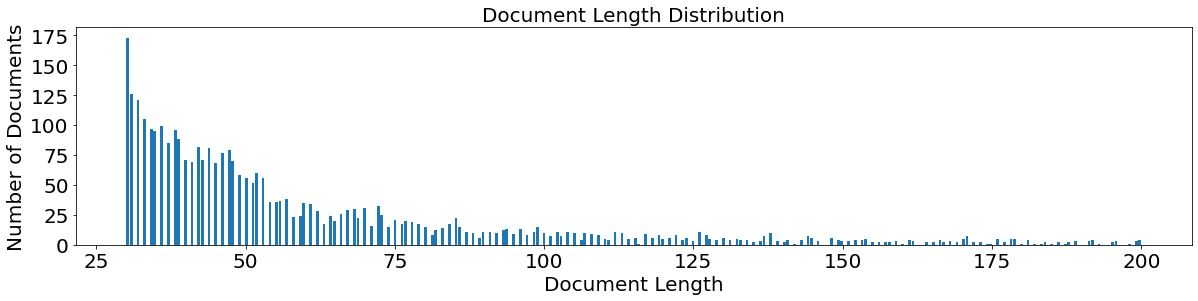

In [27]:
lengths = {u:len(doc) for (u, doc) in users_to_documents.items()}
min = np.min(list(lengths.values()))
max = np.max(list(lengths.values()))
bins = np.linspace(start=min, stop=max, num=300, endpoint=True)

labels = list(range(299))

lengths_df = pd.DataFrame({'Doc': list(lengths.keys()), 'Document Length': list(lengths.values())})

ax = lengths_df.hist(figsize=(20, 4), grid=False, bins=len(bins), range=(30, 200), rwidth=0.8)
ax[0][0].set_title('Document Length Distribution', fontsize=20)
ax[0][0].set_xlabel('Document Length', fontsize=20)
ax[0][0].set_ylabel('Number of Documents', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('document_length_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

### Filter out any users that now have less than 120 tokens

In [28]:
print(len(users_to_documents.values()))
users_to_documents_doc_length_filtered = {u:doc for (u, doc) in users_to_documents.items() if len(doc) >= 120}
print(len(users_to_documents_doc_length_filtered.values()))

25558
557


## Lexical diversity

In [29]:
def lexical_diversity_percentage(tokens):
    return len(set(tokens)) / len(tokens) * 100

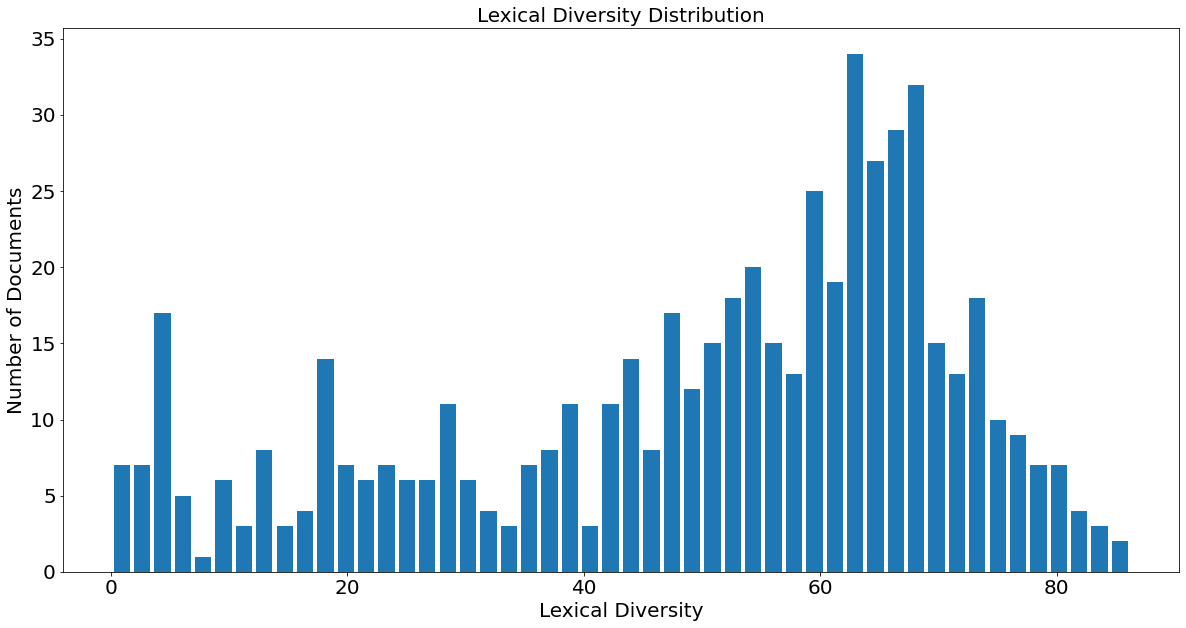

In [30]:
lexical_diversities = {u:lexical_diversity_percentage(doc) for (u, doc) in users_to_documents_doc_length_filtered.items()}
lexical_div_df = pd.DataFrame({'Doc': list(lexical_diversities.keys()), 'Lexical Diversity': list(lexical_diversities.values())})
ax = lexical_div_df.hist(grid=False, bins=50, figsize=(20, 10), rwidth=0.8)
ax[0][0].set_title('Lexical Diversity Distribution', fontsize=20)
ax[0][0].set_xlabel('Lexical Diversity', fontsize=20)
ax[0][0].set_ylabel('Number of Documents', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('lexical_diversity_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

### Filter out any users with a very low lexical diversity

In [31]:
print(len(users_to_documents_doc_length_filtered))
users_to_documents_filtered = {u:doc for (u, doc) in users_to_documents_doc_length_filtered.items() if lexical_diversity_percentage(doc) >= 48}
len(users_to_documents_filtered)

557


353

## Construction of the Tf-Idf Matrix

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
docs = users_to_documents_filtered.values()

In [34]:
def do_nothing(tokens):
    return tokens

vectorizer = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, min_df=0.2, max_df=0.8)

X = vectorizer.fit_transform(docs)

In [35]:
tf_idf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [36]:
tf_idf_df

,app,back,bad,big,billion,business,call,car,city,come,...,uberlyftstrike,ubers,use,want,way,week,well,work,would,year
0,0.000000,0.000000,0.000000,0.150970,0.000000,0.000000,0.000000,0.122063,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.314296,0.168043,0.000000,0.14236,0.000000,0.000000
1,0.000000,0.093225,0.091355,0.329944,0.000000,0.000000,0.000000,0.000000,0.000000,0.080736,...,0.000000,0.000000,0.082846,0.248538,0.343444,0.000000,0.000000,0.00000,0.082129,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.133195,0.000000,0.000000,0.231187,0.000000,0.000000,...,0.000000,0.153039,0.143593,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.304838,0.000000,0.000000,0.000000,0.000000,0.199172,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.111713,0.000000,0.099984,0.00000,0.000000,0.000000
4,0.160799,0.000000,0.094047,0.000000,0.000000,0.000000,0.000000,0.068657,0.000000,0.000000,...,0.000000,0.000000,0.085287,0.085287,0.000000,0.094519,0.000000,0.00000,0.169098,0.152139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0.196130,0.000000,0.000000,0.000000,0.000000,0.096109,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.104027,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
349,0.418580,0.000000,0.000000,0.000000,0.102968,0.102558,0.061204,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
350,0.145019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123838,0.000000,0.000000,...,0.174911,0.000000,0.153835,0.153835,0.000000,0.000000,0.142695,0.14443,0.152504,0.137209
351,0.256276,0.000000,0.000000,0.000000,0.000000,0.376747,0.299779,0.000000,0.150642,0.000000,...,0.000000,0.000000,0.135928,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [37]:
tf_idf_df.iloc[:10, 60:70]

,stock,strike,take,taxi,think,time,today,try,uberipo,uberlyftstrike
0,0.000000,0.000000,0.117117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.517245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164972,0.0
2,0.512295,0.000000,0.110910,0.143593,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.090565,0.000000,0.000000,0.000000,0.0
4,0.000000,0.082074,0.065875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.000000,0.112894,0.000000,0.000000,0.122805,0.000000,0.168845,0.000000,0.0
6,0.000000,0.000000,0.000000,0.156812,0.162519,0.000000,0.000000,0.000000,0.000000,0.0
7,0.224740,0.000000,0.000000,0.000000,0.000000,0.000000,0.034212,0.000000,0.000000,0.0
8,0.000000,0.000000,0.103318,0.000000,0.138632,0.224779,0.000000,0.000000,0.000000,0.0
9,0.000000,0.000000,0.000000,0.267105,0.000000,0.000000,0.000000,0.154279,0.132972,0.0


In [38]:
tfidf_file = open('tfidf.pickle', 'wb')
pickle.dump(tf_idf_df, tfidf_file)
tfidf_file.close()

## Optional: Load the tf-idf Matrix from Pickle

In [39]:
tfidf_file = open('tfidf.pickle', 'rb')
tf_idf_df = pickle.load(tfidf_file)
tfidf_file.close()

# Perform the PCA

In [40]:
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.normalize(tf_idf_df), columns=tf_idf_df.columns)

In [41]:
pca = PCA(n_components=30)
X_reduced = pca.fit_transform(data_scaled)

In [42]:
len(X_reduced)

353

## Analyze the Percentage of explained Variance per Principal Component

In [43]:
pd.DataFrame(data={'PCA': [i+1 for i in range(0, len(pca.explained_variance_ratio_))],'Explained Variance': pca.explained_variance_ratio_})

,PCA,Explained Variance
0,1,0.125383
1,2,0.077134
2,3,0.054076
3,4,0.049704
4,5,0.038319
5,6,0.033597
6,7,0.028052
7,8,0.024165
8,9,0.023803
9,10,0.021019


In [44]:
explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(int(explained_variance * 100)))

Explained variance of the PCA step: 74%


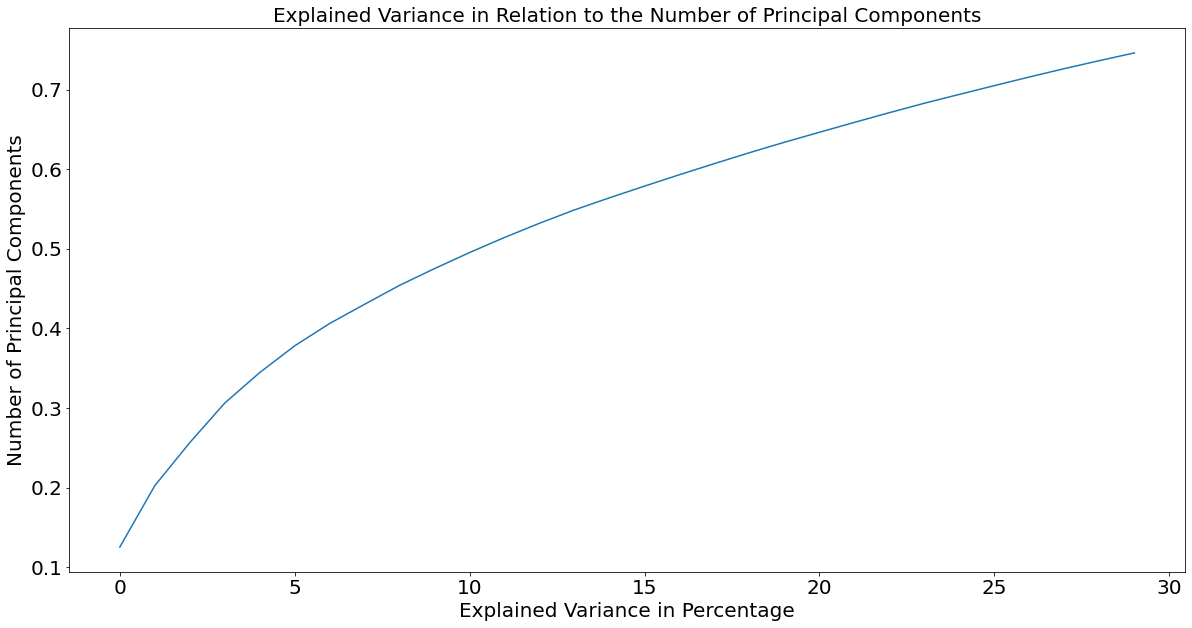

In [45]:
plt.figure(figsize=(20, 10))
ax = plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance in Relation to the Number of Principal Components', fontsize=20)
plt.xlabel('Explained Variance in Percentage', fontsize=20)
plt.ylabel('Number of Principal Components', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('explained_variance.pdf', bbox_inches='tight')
plt.show()
plt.close()

## 2D Plot

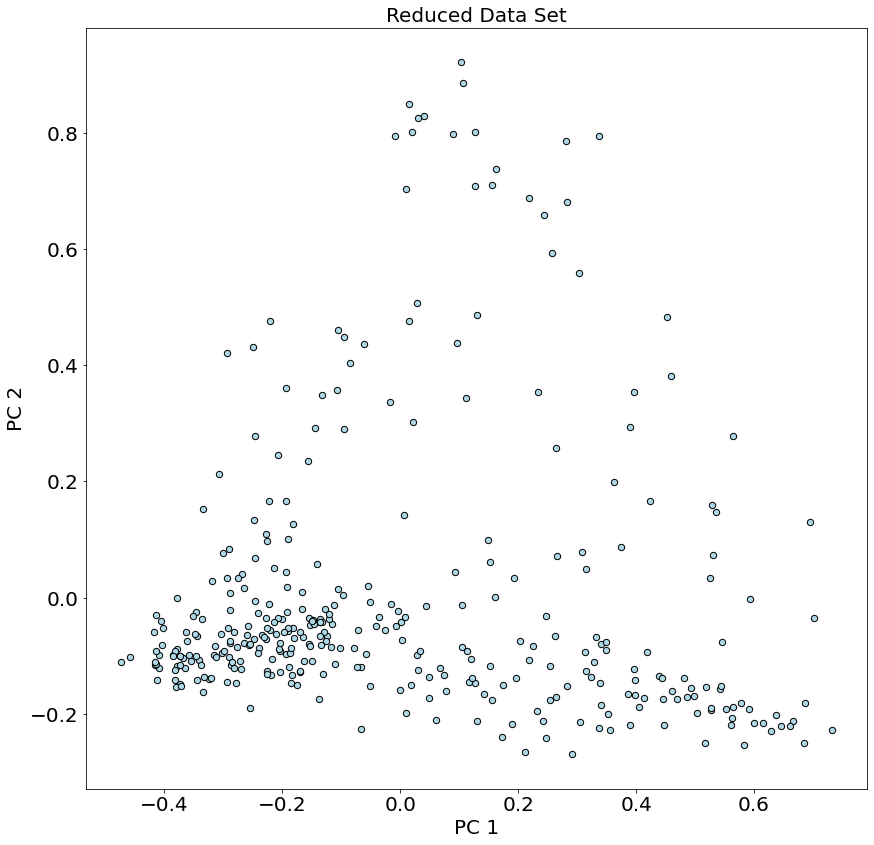

In [46]:
plt.figure(1, figsize=(14, 14))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='lightblue', edgecolor='black', s=40)
plt.title('Reduced Data Set', fontsize=20)
plt.xlabel('PC 1', fontsize=20)
plt.ylabel('PC 2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('pca_first_2_pcs.pdf', bbox_inches='tight')
plt.show()
plt.close()

## 3D Plot

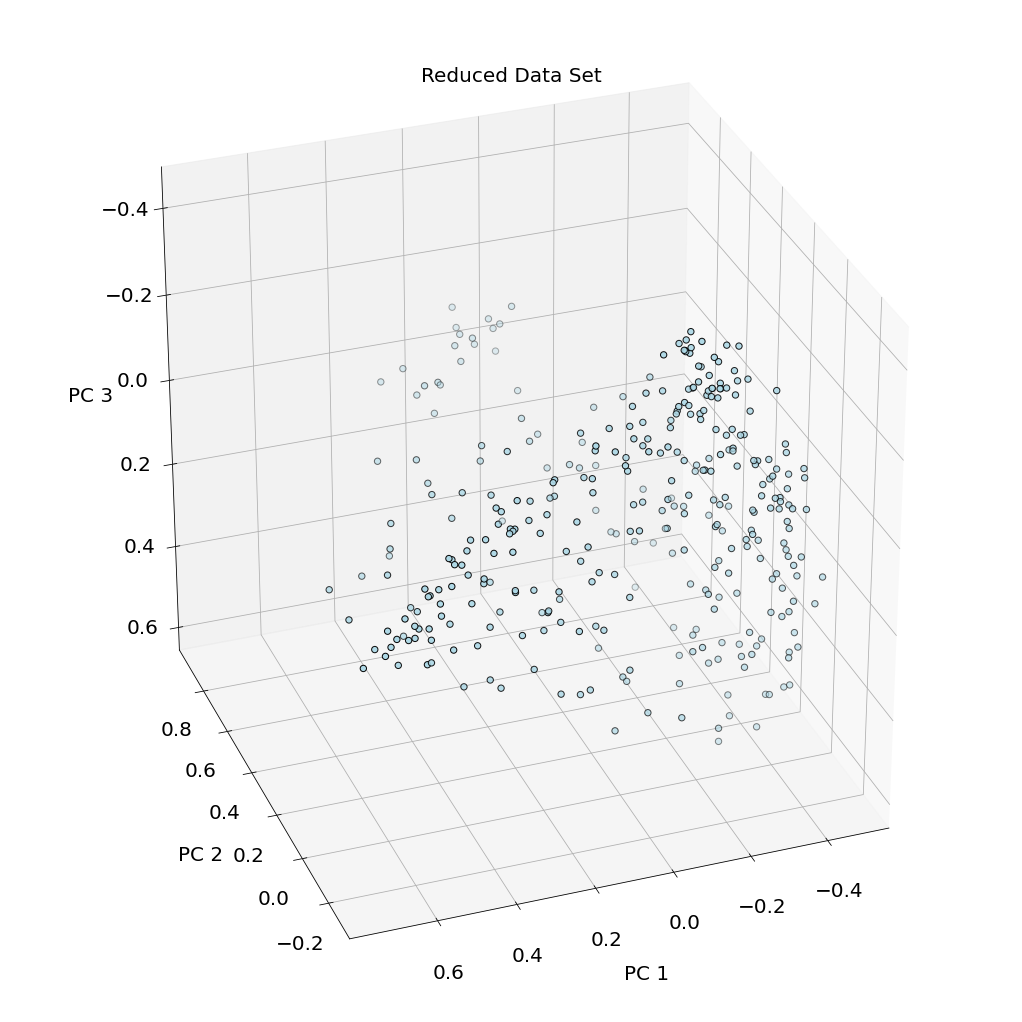

In [47]:
fig = plt.figure(1, figsize=(14, 14))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], color='lightblue', edgecolor='black', s=40)
ax.set_title('Reduced Data Set', fontsize=20)
ax.set_xlabel('PC 1', fontsize=20, labelpad=40)
ax.set_ylabel('PC 2', fontsize=20, labelpad=40)
ax.set_zlabel('PC 3', fontsize=20, labelpad=40)
ax.tick_params(labelsize=20, pad=20)
plt.savefig('pca_first_3_pcs.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [48]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important_feature_indexes_per_pc = {}

initial_feature_names = data_scaled.columns

dfs = []

for pc in range(n_pcs):
    components_enumerated = list(enumerate(pca.components_[pc]))
    components_sorted = sorted(components_enumerated, key=lambda x:np.abs(x[1]), reverse=True)
    features_imps = {initial_feature_names[i]:imp for (i, imp) in components_sorted}
    features_imps_df = pd.DataFrame.from_dict(features_imps, orient='index', columns = ['importance'] )[:10]
    dfs.append(features_imps_df)
    
print(dfs[0])
print()
print(dfs[1])
print()
print(dfs[2])

                importance
ipo               0.680243
driver           -0.389888
stock             0.210885
uberlyftstrike   -0.186251
billion           0.182166
price             0.143981
share             0.143515
market            0.134462
public            0.131463
investor          0.124639

                importance
uberipo           0.934133
ipo              -0.236044
driver           -0.101842
car              -0.096105
billion          -0.072423
strike           -0.070060
uberlyftstrike    0.066637
rideshare        -0.064721
ride             -0.062816
app              -0.060335

                importance
uberlyftstrike    0.552496
driver            0.519282
strike            0.297654
ipo               0.264821
taxi             -0.213645
know             -0.152077
pay               0.148680
car              -0.134816
ride             -0.129205
get              -0.126066


# K-Means Clustering

In [84]:
from sklearn.cluster import KMeans
from sklearn import metrics

## Perfoming the Clustering

In [85]:
km = KMeans(n_clusters=3)
km.fit(X_reduced)

KMeans(n_clusters=3)

## 2D Plot

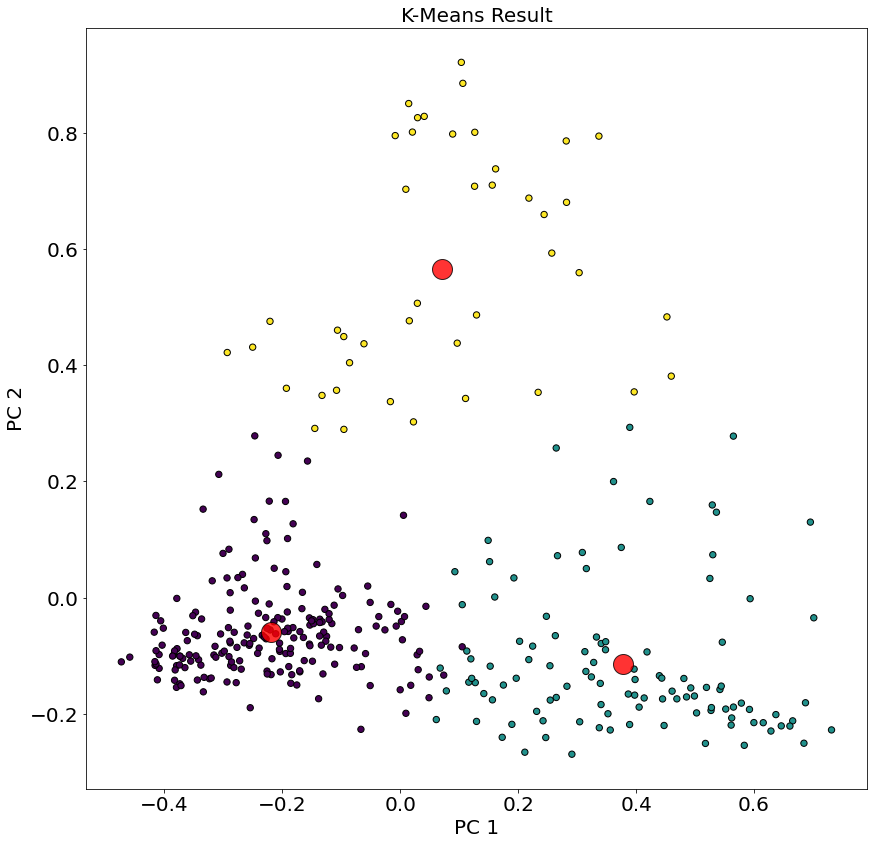

In [86]:
y_kmeans = km.labels_
plt.figure(figsize=(14, 14))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_kmeans, s=40, edgecolor='black')
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=400, alpha=0.8, edgecolor='black')
plt.tick_params(labelsize=20)
plt.xlabel('PC 1', fontsize=20)
plt.ylabel('PC 2', fontsize=20)
plt.title('K-Means Result', fontsize=20)
plt.savefig('k_means_result_2d.pdf', bbox_inches='tight')
plt.show()
plt.close()

## 3D Plot

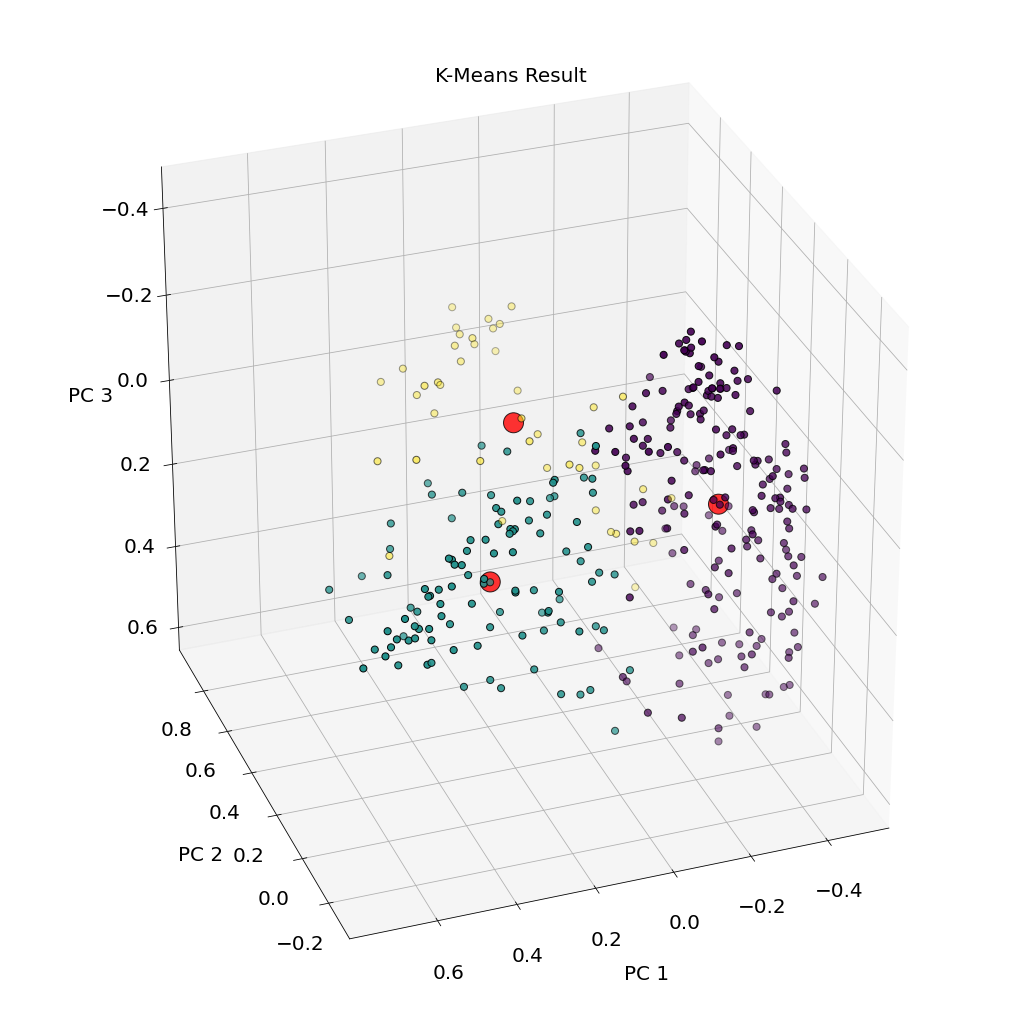

In [87]:
fig = plt.figure(1, figsize=(14, 14))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = Axes3D(fig, elev=-150, azim=110)
y = range(0, len(X_reduced))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_kmeans, edgecolor='k', s=50)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=400, alpha=0.8, edgecolor='black')
ax.set_title('K-Means Result', fontsize=20)

ax.set_xlabel('PC 1', fontsize=20, labelpad=40)
ax.set_ylabel('PC 2', fontsize=20, labelpad=40)
ax.set_zlabel('PC 3', fontsize=20, labelpad=40)
ax.tick_params(labelsize=20, pad=20)
plt.savefig('k_means_result_3d.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Get the Users per Clusters

In [88]:
users_df = pd.DataFrame({'Username': list(users_to_documents_filtered.keys()), 'Cluster Label': km.labels_})

for i in range(0, len(users_df)):
    p = X_reduced[i]
    cluster = users_df.loc[i]['Cluster Label']
    
users_cluster_0 = users_df[users_df['Cluster Label'] == 0]
users_cluster_1 = users_df[users_df['Cluster Label'] == 1]
users_cluster_2 = users_df[users_df['Cluster Label'] == 2]

## Retweets per individual user for each cluster

In [89]:
retweet_count_per_users_cluster_0 = {u:0 for u in list(users_cluster_0['Username'])}
retweet_count_per_users_cluster_1 = {u:0 for u in list(users_cluster_1['Username'])}
retweet_count_per_users_cluster_2 = {u:0 for u in list(users_cluster_2['Username'])}

for t in tweets:
    username = t['username']
    retweets = t['retweets_count']
    if username in retweet_count_per_users_cluster_0:
        retweet_count_per_users_cluster_0[username] += retweets
    if username in retweet_count_per_users_cluster_1:
        retweet_count_per_users_cluster_1[username] += retweets
    if username in retweet_count_per_users_cluster_2:
        retweet_count_per_users_cluster_2[username] += retweets
        
ten_most_retweeted_cluster_0 = pd.DataFrame({'Username': list(retweet_count_per_users_cluster_0.keys()), 'Retweets': list(retweet_count_per_users_cluster_0.values())}).sort_values(by='Retweets')[::-1].head(15)
ten_most_retweeted_cluster_1 = pd.DataFrame({'Username': list(retweet_count_per_users_cluster_1.keys()), 'Retweets': list(retweet_count_per_users_cluster_1.values())}).sort_values(by='Retweets')[::-1].head(15)
ten_most_retweeted_cluster_2 = pd.DataFrame({'Username': list(retweet_count_per_users_cluster_2.keys()), 'Retweets': list(retweet_count_per_users_cluster_2.values())}).sort_values(by='Retweets')[::-1].head(15)


tweets_cluster_0 = []
tweets_cluster_1 = []
tweets_cluster_2 = []

for t in tweets:
    username = t['username']
    tweet = t['tweet']
    if username in list(ten_most_retweeted_cluster_0['Username']):
        tweets_cluster_0.append(t)
    if username in list(ten_most_retweeted_cluster_1['Username']):
        tweets_cluster_1.append(t)
    if username in list(ten_most_retweeted_cluster_2['Username']):
        tweets_cluster_2.append(t)

In [90]:
print(ten_most_retweeted_cluster_0)
print()
print(ten_most_retweeted_cluster_1)
print()
print(ten_most_retweeted_cluster_2)

            Username  Retweets
76       dddaughters      2376
190  anthony18334957      1100
119  londontrafficw1      1091
120  californialabor       518
103       dgorganize       293
195         nicoemoe       273
98          nelpnews       253
30     adriancroydon       223
129  fitzthereporter       218
65    gigworkersrise       207
165     teamsters117       113
95         quicktake       111
7       ianjparrott1        91
44   love_in_loveout        80
87         malicodes        77

            Username  Retweets
95   schuldensuehner       344
32       trust4keeps       195
53    gerberkawasaki       113
68             etoro       100
81         susanlitv        89
67       planetponzi        78
52    spirosmargaris        77
96     4awesometweet        70
1        longmanbach        63
50           argoexp        54
82         zyiteblog        34
107           pymnts        31
29      _algocapital        29
79        edgecgroup        27
66            kpixtv        26

      

## VADER Sentiment Analysis

In [91]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sentiments_cluster_0_df = pd.DataFrame(columns=['Link', 'Sentence', 'Pos', 'Neu', 'Neg', 'Compound'])
sentiments_cluster_1_df = pd.DataFrame(columns=['Link', 'Sentence', 'Pos', 'Neu', 'Neg', 'Compound'])
sentiments_cluster_2_df = pd.DataFrame(columns=['Link', 'Sentence', 'Pos', 'Neu', 'Neg', 'Compound'])


for t in tweets_cluster_0:
    ss = sid.polarity_scores(t['tweet'])
    sentiments_cluster_0_df = sentiments_cluster_0_df.append({'Link': t['link'],
                                                              'Sentence': t['tweet'],
                                                             'Pos': ss['pos'],
                                                             'Neu': ss['neu'],
                                                             'Neg': ss['neg'],
                                                             'Compound': ss['compound']}, ignore_index=True)
    
for t in tweets_cluster_1:
    ss = sid.polarity_scores(t['tweet'])
    sentiments_cluster_1_df = sentiments_cluster_1_df.append({'Link': t['link'],
                                                              'Sentence': t['tweet'],
                                                             'Pos': ss['pos'],
                                                             'Neu': ss['neu'],
                                                             'Neg': ss['neg'],
                                                             'Compound': ss['compound']}, ignore_index=True)

for t in tweets_cluster_2:
    ss = sid.polarity_scores(t['tweet'])
    sentiments_cluster_2_df = sentiments_cluster_2_df.append({'Link': t['link'],
                                                              'Sentence': t['tweet'],
                                                             'Pos': ss['pos'],
                                                             'Neu': ss['neu'],
                                                             'Neg': ss['neg'],
                                                             'Compound': ss['compound']}, ignore_index=True)

In [92]:
sentiments_cluster_2_df.sort_values(by='Compound')[::1].head(10).values

array([['https://twitter.com/PaulDDDaughters/status/1125904016234434560',
        'It’s disportioncate to to ban #Uber for failing to report #Sexualassaults and for failing to tell authorities that it paid of #hackers to hide the truth(Illegal).Yet the #Conservative sponsored vultures in the #CityOfLondon will be throwing money at this loss making Ponzi  #IPO pic.twitter.com/QJ6FeCJ2RV',
        0.0, 0.693, 0.307, -0.9416],
       ['https://twitter.com/_drivers_united/status/1124448815488962560',
        'When Tammie Jean fell ill with cancer, her world turned upside-down. A massage therapist, she needed to find a new way to provide for her daughter.With #uber she could work around dr visits and disability, until the pay cuts ruined it. #RideshareReality https://youtu.be/3IOeq1ZcXco\xa0',
        0.0, 0.721, 0.279, -0.9169],
       ['https://twitter.com/PaulDDDaughters/status/1132420830217035776',
        'BitTorrent is it a choice no it’s illegal just like #Uber in most countries . Wh

## Get the tweets per cluster

In [93]:
tweets_cluster0 = [t for t in tweets if t['username'] in list(users_cluster_0['Username'])]    
tweets_cluster1 = [t for t in tweets if t['username'] in list(users_cluster_1['Username'])]
tweets_cluster2 = [t for t in tweets if t['username'] in list(users_cluster_2['Username'])]
texts_cluster0 = [t['tweet'] for t in tweets_cluster0]
texts_cluster1 = [t['tweet'] for t in tweets_cluster1]
texts_cluster2 = [t['tweet'] for t in tweets_cluster2]
print(len(texts_cluster0))
print(len(texts_cluster1))
print(len(texts_cluster2))

2676
1866
1042


## Most used hashtags in the cluster

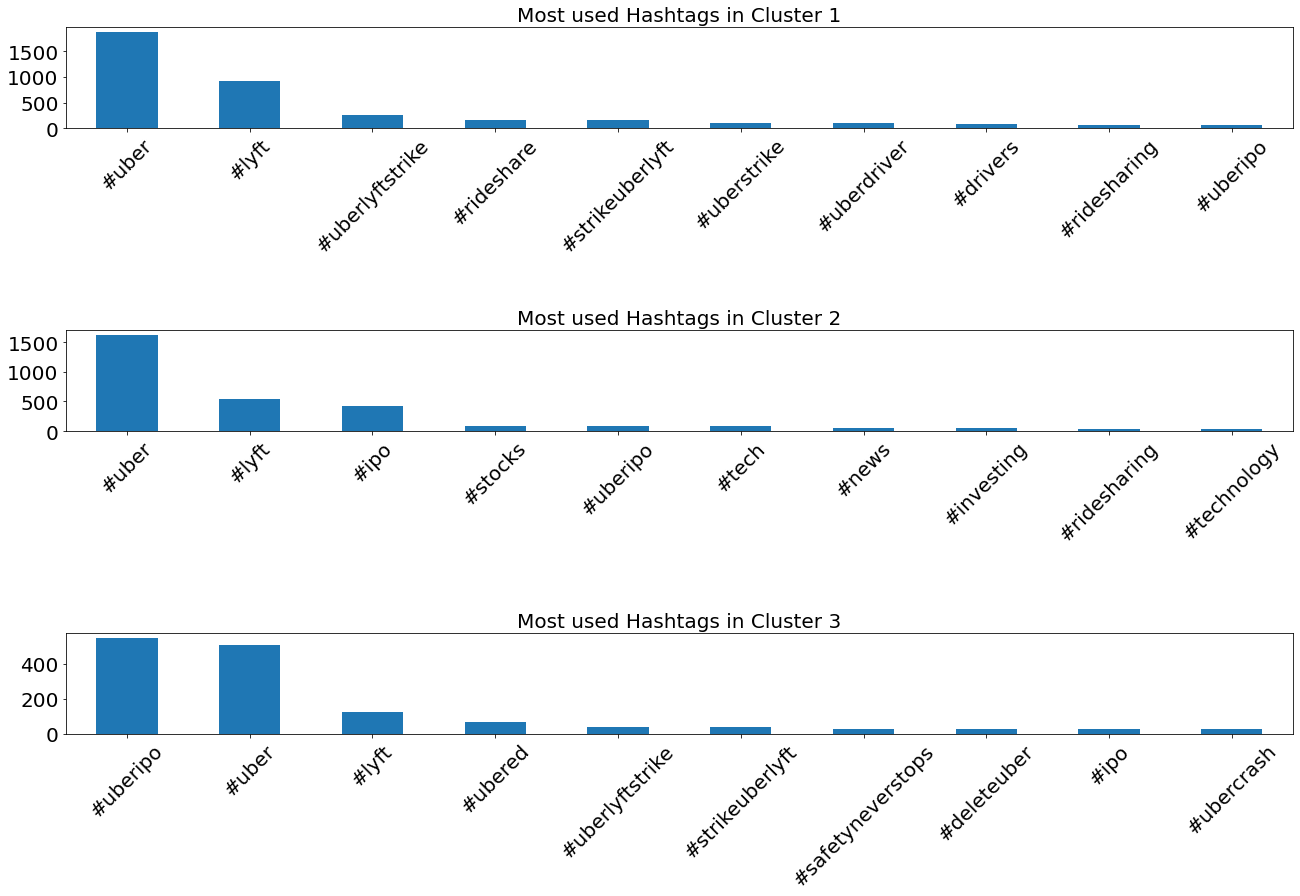

In [94]:
from collections import Counter

hashtags_cluster0 = [h for t in tweets_cluster0 for h in t['hashtags']]
hashtags_cluster1 = [h for t in tweets_cluster1 for h in t['hashtags']]
hashtags_cluster2 = [h for t in tweets_cluster2 for h in t['hashtags']]


c0 = Counter(hashtags_cluster0)
c1 = Counter(hashtags_cluster1)
c2 = Counter(hashtags_cluster2)

df0 = pd.DataFrame(index=[e[0] for e in c0.most_common(10)], data={'count': [e[1] for e in c0.most_common(10)]}).sort_values(by='count')[::-1]
df1 = pd.DataFrame(index=[e[0] for e in c1.most_common(10)], data={'count': [e[1] for e in c1.most_common(10)]}).sort_values(by='count')[::-1]
df2 = pd.DataFrame(index=[e[0] for e in c2.most_common(10)], data={'count': [e[1] for e in c2.most_common(10)]}).sort_values(by='count')[::-1]

fig, axes = plt.subplots(3, 1, figsize=(22, 13))

plt.subplots_adjust(hspace=2)

df0.plot(ax=axes[0], kind='bar', title='Most used Hashtags in Cluster 1', legend=False, fontsize=20)
df1.plot(ax=axes[1], kind='bar', title='Most used Hashtags in Cluster 2', legend=False, fontsize=20)
df2.plot(ax=axes[2], kind='bar', title='Most used Hashtags in Cluster 3', legend=False, fontsize=20)

for i in range(3):
    axes[i].title.set_size(20)
    axes[i].tick_params(axis='x', labelrotation=45)

plt.savefig('most_used_hashtags_per_cluster.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Number of Tweets per day per cluster

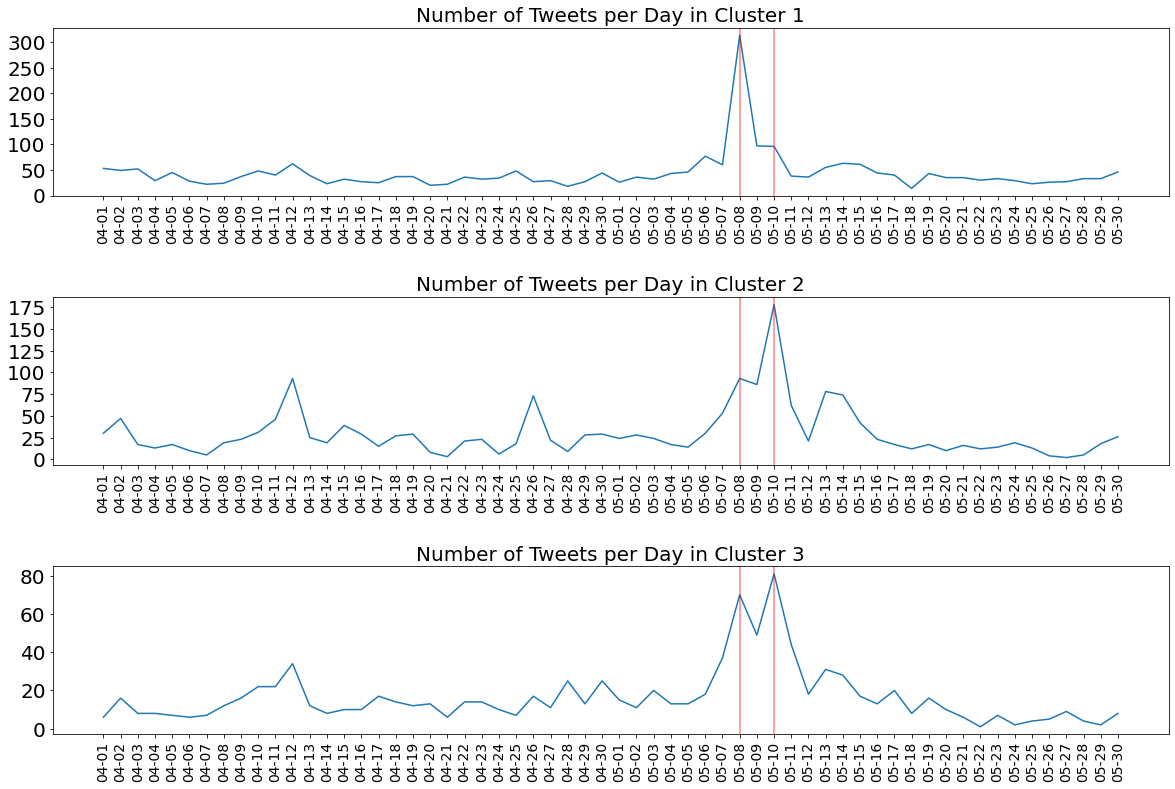

In [102]:
clusters = [tweets_cluster0, tweets_cluster1, tweets_cluster2]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3,1, figsize=(20, 13))
plt.subplots_adjust(hspace=0.6)
i = 0
for c in clusters:
    dates_to_n_tweets = {}
    for t in c:
        date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
        try:
            dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
        except:
            dates_to_n_tweets[date] = 0

    sorted_dates = sorted(dates_to_n_tweets.items())
    df = pd.DataFrame({'date': [e[0] for e in sorted_dates], 'count': [e[1] for e in sorted_dates]})
    ax = df.plot(ax=axes[i], kind='line', title='Number of Tweets per Day in Cluster %d' % (i+1), legend=False, fontsize=20)
    xlabels = df['date']
    ax.set_xticklabels(xlabels, fontsize=14, rotation=90)
    ax.set_xticks(range(len(xlabels)))
    ax.axvline(x=37, color='red', alpha=0.5)
    ax.axvline(x=39, color='red', alpha=0.5)
    i+=1
    
axes[0].title.set_size(20)
axes[1].title.set_size(20)
axes[2].title.set_size(20)

plt.savefig('tweets_per_day_per_cluster.pdf', bbox_inches='tight')
plt.show()
plt.close()

## Four most liked tweets per cluster

In [96]:
tweets_cluster0_sorted = sorted(tweets_cluster0, key=lambda t: t['likes_count'], reverse=True)
tweets_cluster1_sorted = sorted(tweets_cluster1, key=lambda t: t['likes_count'], reverse=True)
tweets_cluster2_sorted = sorted(tweets_cluster2, key=lambda t: t['likes_count'], reverse=True)

print(*[t for t in tweets_cluster0_sorted[:4]], sep='\n_________________________________________\n\n\n')
print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
print(*[t for t in tweets_cluster1_sorted[:4]], sep='\n_________________________________________\n\n\n')
print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
print(*[t for t in tweets_cluster2_sorted[:4]], sep='\n_________________________________________\n\n\n')

{'id': 1125588567508639744, 'conversation_id': '1125588567508639744', 'created_at': 1557196201000, 'date': '2019-05-07', 'time': '04:30:01', 'timezone': '+0200', 'user_id': 3586961474, 'username': 'dgorganize', 'name': 'Daniel Gross', 'place': '', 'tweet': 'I imagine some Uber and Lyft tech workers are grappling right now with whether to respect Wed’s strike.\n\nIt starts with a conversation with a single co-worker. “I’m thinking of walking out with the drivers, would you join me?”\n\n #StrikeUberLyft', 'language': 'en', 'mentions': [], 'urls': [], 'photos': [], 'replies_count': 10, 'retweets_count': 153, 'likes_count': 460, 'hashtags': ['#strikeuberlyft'], 'cashtags': [], 'link': 'https://twitter.com/dgorganize/status/1125588567508639744', 'retweet': False, 'quote_url': '', 'video': 0, 'near': '', 'geo': '', 'source': '', 'user_rt_id': '', 'user_rt': '', 'retweet_id': '', 'reply_to': [{'user_id': '3586961474', 'username': 'dgorganize'}], 'retweet_date': '', 'translate': '', 'trans_src

# Shifterator Analysis

In [ ]:
import shifterator as sh

In [ ]:
tokens_cluster0 = [t for (u, doc) in users_to_documents_doc_length_filtered.items() if u in list(users_cluster_0['Username']) for t in doc]    
tokens_cluster1 = [t for (u, doc) in users_to_documents_doc_length_filtered.items() if u in list(users_cluster_1['Username']) for t in doc]    
tokens_cluster2 = [t for (u, doc) in users_to_documents_doc_length_filtered.items() if u in list(users_cluster_2['Username']) for t in doc]    

In [ ]:
token_freqs_cluster_0 = dict(Counter(tokens_cluster0))
token_freqs_cluster_1 = dict(Counter(tokens_cluster1))
token_freqs_cluster_2 = dict(Counter(tokens_cluster2))

In [ ]:
shift = sh.ProportionShift(type2freq_1=token_freqs_cluster_0, type2freq_2=token_freqs_cluster_2)
shift.get_shift_graph(system_names = ['Cluster 1', 'Cluster 3'], filename='entropy_shift_cluster1_cluster3.pdf')